## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Get Segment Anything Model (SAM) up and running

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Sourdough Specifics

In [4]:
folder_path = '/mnt/c/developer/timelapse/stills/'

center_point = [275,410]

input_points = np.array([center_point,[center_point[0]-50, center_point[1]],[center_point[0]+50, center_point[1]],
                        [center_point[0], center_point[1]-50],[center_point[0], center_point[1]+50]])
input_labels = np.array([1,1,1,1,1])

soft_frame_cap = 500 # Over this value, we will start skipping frames to avoid memory errors and too big/too slow movies

In [5]:
import os
from pathlib import Path


# Define a function to quickly list all files in a directory
def list_files(directory):
    # Initialize an empty list to store file names
    file_list = []
    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Add the files to the list
        file_list.extend(files)
    return file_list


filenames = list_files(folder_path)

def sort_and_filter_files(filenames):
    # Filter the filenames to include only those with the 'jpg' extension
    filtered_files = [file for file in filenames if file.lower().endswith('.jpg')]
    # Sort the filtered files in ascending order
    sorted_and_filtered_files = sorted(filtered_files)
    return sorted_and_filtered_files

file_list = sort_and_filter_files(filenames)

Sourdough Size: 103160


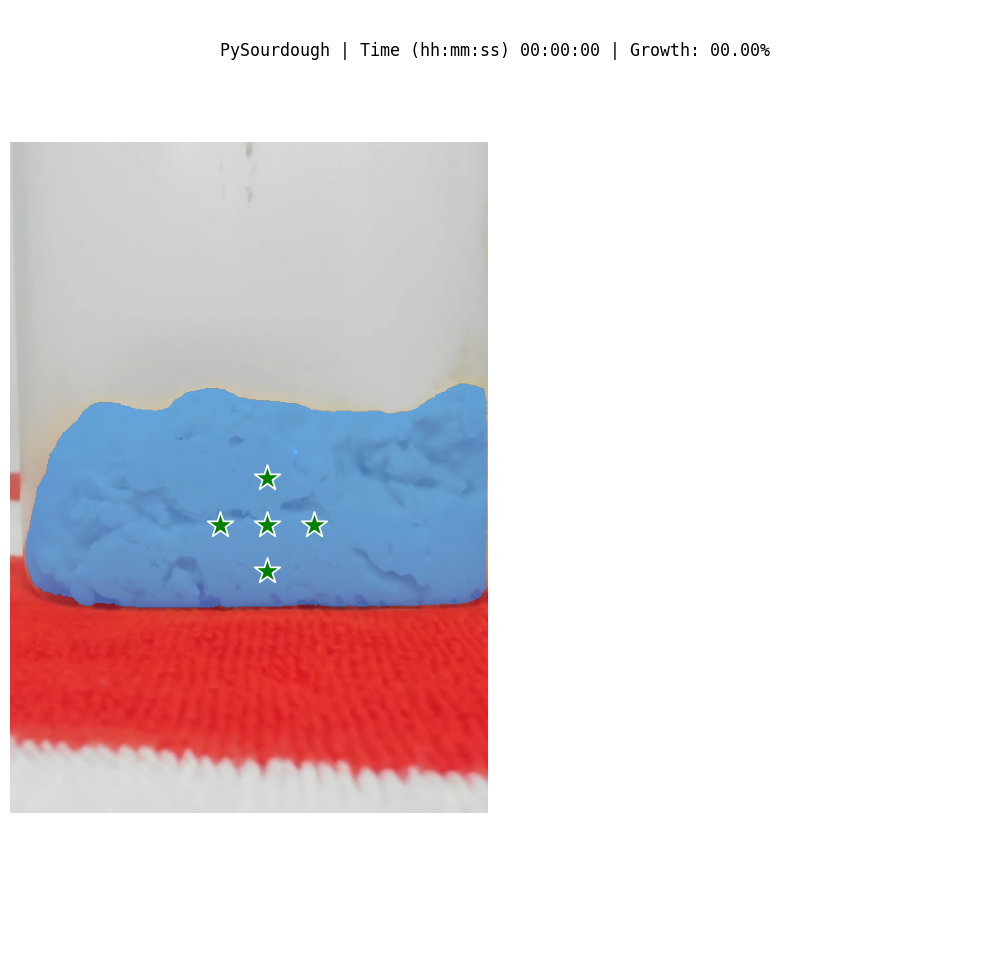

In [6]:
# Test positioning

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

def get_sourdough_mask_from_image(image):
    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True,
    )


    best_mask = masks[1]

    return best_mask




def center_crop_cv2(image, crop_percentage=0.3):
    """
    Center-crops an OpenCV image (NumPy array) by removing the specified percentage from both sides.
    
    Args:
        image (numpy.ndarray): Input image (OpenCV format).
        crop_percentage (float, optional): Percentage of width to crop from both sides. Defaults to 0.3 (30%).
    
    Returns:
        numpy.ndarray: Center-cropped image (OpenCV format).
    """
    # Get image dimensions
    height, width, _ = image.shape
    
    # Calculate cropping boundaries
    crop_width = int(width * (1 - 2 * crop_percentage))
    left = (width - crop_width) // 2
    right = left + crop_width
    
    # Crop the center of the image
    cropped_image = image[:, left:right]
    
    return cropped_image


image_path = folder_path + file_list[0]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = center_crop_cv2(image)
mask = get_sourdough_mask_from_image(image)
sourdough_size = np.sum(mask)

print(f"Sourdough Size: {sourdough_size}")



def get_canvas(image,mask, input_points, input_labels, time_string, growth_string,show_prompt=True):
    fig, (left,right) = plt.subplots(1,2,figsize=(10, 10))
    left.imshow(image)
    left.axis('off')
    right.axis('off')
    show_mask(mask, left)
    if show_prompt:
        show_points(input_points, input_labels, left)

    #Pad the growth_string with 0's on the left to make it 6 characters long.
    growth_string = growth_string.zfill(6)

    fig.suptitle(f'PySourdough | Time (hh:mm:ss) {time_string} | Growth: {growth_string}', y=0.92)

    fig.tight_layout()
    
    return fig

fig = get_canvas(image,mask, input_points, input_labels, "00:00:00", "0.00%")

#print sourdough size formatted as a percentage



In [7]:
# Write out the current config to data/config.json. This will be picked up later by alarm.py during the alarm process.
import json

def write_config_to_file(input_points, input_labels):
    # Create a dictionary with the current coordinates and labels
    config_dict = {
        "input_points": input_points.tolist(),
        "input_labels": input_labels.tolist(),
        "folder_path": folder_path
    }

    # Write the dictionary to a JSON file
    with open("data/config.json", "w") as file:
        json.dump(config_dict, file)

write_config_to_file(input_points, input_labels)

In [8]:
# Let's create a movie of the masks.
from tqdm import tqdm

from pathlib import Path
import time


#For each file in file_list, calculate the sourdough size and then store the sourdough size and the filename as tuples in a list
sourdough_sizes = []

# make a subfolder named "processed" if it doesn't exist already
Path(folder_path + "processed").mkdir(parents=True, exist_ok=True)

def get_processed_filename(input_filename):
    # Remove file extension
    base_filename, _ = os.path.splitext(input_filename)

    processed_dir = os.path.join(os.path.dirname(base_filename), "processed")
    
    # Construct processed image filename
    processed_filename = os.path.join(processed_dir, os.path.basename(base_filename) + ".png")
    
    return processed_filename

import datetime

def convert_filename_to_datetime(filename):
    #get last index of "." from filename
    last_dot_index = filename.rfind(".")
    last_slash_index = filename.rfind("/")
    utc_time_string = filename[last_slash_index+1:last_dot_index]

    try:
        # Parse the UTC time string into a datetime object
        start_date_time = datetime.datetime.strptime(utc_time_string, '%Y-%m-%dT%H_%M_%S.%f')
        return start_date_time
    except ValueError:
        print(f"Invalid UTC datetime format: {utc_time_string} Please provide a valid string (e.g., '2024-04-27T20_41_44.755476').")
        return None

start_date_time = convert_filename_to_datetime(file_list[0])

plt.figure(figsize=(10,10))

def calculate_time_difference_string(current_date_time, start_date_time):
    # Calculate the time difference
    time_delta = current_date_time - start_date_time

    # Extract hours, minutes, and seconds
    total_seconds = time_delta.total_seconds()
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Format the result as hh:mm:ss
    time_difference_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"
    return time_difference_str

mask_sizes = []
minutes = []
growth_percentages = []

current_count = 0

# matplotlib seems to explode when this gets too big, so we will trim down the file list if there are over soft_cap files.

if len(file_list) > soft_frame_cap:
    every_n = len(file_list) // soft_frame_cap
    print(f"Only using every {every_n}th file.")
    file_list = file_list[::every_n]

for file in tqdm(file_list):
    current_count += 1

    if current_count % 20 == 0:
        plt.close('all')
        
    
    image_path = folder_path + file

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = center_crop_cv2(image)
    mask = get_sourdough_mask_from_image(image)
    mask_size = np.sum(mask)

    mask_sizes.append(mask_size)

    #Title Stuff
    current_date_time = convert_filename_to_datetime(image_path)
    time_difference = current_date_time - start_date_time

    time_difference_minutes = int(time_difference.total_seconds() / 60)
    minutes.append(time_difference_minutes)

    # Calculate both the growth percentage and the time.
    # As of right now, calculating and remembering the time is probably unnecessary as it is simply
    # one per minute. However, by getting this in below as a calculation, it enables us to change the
    # frame rate of the capture without breaking this part of the code, so we will just do the extra
    # calculations for now for the sake of redundancy.
    time_difference_string = calculate_time_difference_string(current_date_time, start_date_time)
    growth_percentage = (mask_size - mask_sizes[0]) / mask_sizes[0] * 100
    growth_percentages.append(growth_percentage)

    #format growth_percentage as a percentage string
    growth_percentage_string = f"{growth_percentage:.2f}%"

    fig = get_canvas(image,mask, input_points, input_labels, time_difference_string, growth_percentage_string, show_prompt=False)

    
    processed_filename = get_processed_filename(image_path)
    fig.savefig(processed_filename,bbox_inches='tight')
    
    #Uncomment out to close the figure after saving. Unforunately, this crashes every time on my personal
    #box, so for now, I just eat the memory leak, as out of memory errors are less annoying than crashing every time.
    #plot.close(fig)

plt.close('all')



Only using every 1th file.


100%|██████████| 718/718 [05:38<00:00,  2.12it/s]


In [9]:
import numpy as np

def get_rolling_average(input_array, window_size):
  """
  This function takes in an input array and a window size and outputs a new array
  where the values are the rolling averages of the input array over the window size.

  Args:
      input_array: A NumPy array of any shape.
      window_size: An integer specifying the window size for the rolling average.

  Returns:
      A NumPy array of the same shape as the input array, containing the rolling averages.
  """
  if window_size < 1:
      raise ValueError("Window size must be a positive integer")
  if window_size > len(input_array):
      raise ValueError("Window size cannot be greater than the length of the input array")

  rolling_average_array = np.empty(len(input_array))
  for i in range(len(input_array)):
      start_index = max(0, i - window_size + 1)
      end_index = i + 1
      window = input_array[start_index:end_index]
      rolling_average_array[i] = np.mean(window)
  return rolling_average_array

# prep the data for the next step
growth_percentage_rolling_avg = get_rolling_average(growth_percentages, 120)
hours = np.array(minutes) / 60

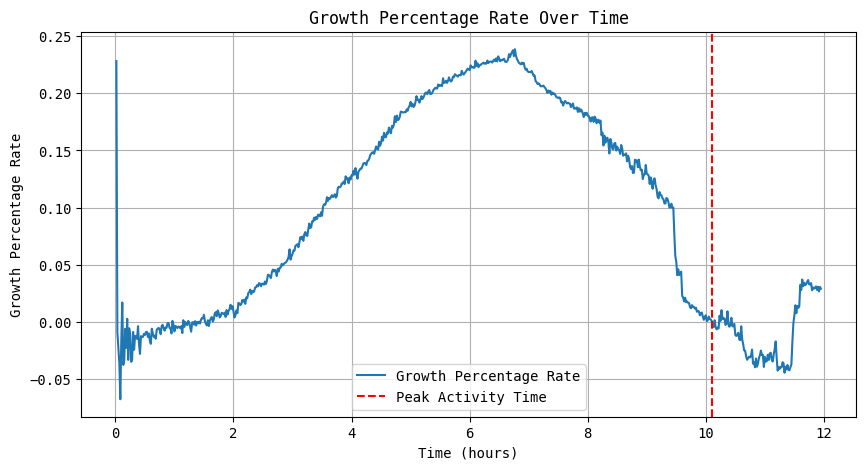

In [10]:
# Peak activity detector. We are going to take a look at the rate of change of the growth percentage. When it goes negative after 4 hours, that will be the peak activity time.

# Calculate the rate of change of the growth percentage
growth_percentage_rate = np.diff(growth_percentage_rolling_avg)

# Find the index where the rate of change goes negative after 4 hours
peak_activity_index = np.argmax((hours[1:] > 4) & (growth_percentage_rate < 0))

# Get the peak activity time in hours
peak_activity_time = hours[peak_activity_index]

# Use matplotlib to graph the growth_percentage_rate
plt.figure(figsize=(10, 5))
plt.plot(hours[1:], growth_percentage_rate, label="Growth Percentage Rate")
plt.axvline(peak_activity_time, color="red", linestyle="--", label="Peak Activity Time")
plt.xlabel("Time (hours)")
plt.ylabel("Growth Percentage Rate")
plt.title("Growth Percentage Rate Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Let's add the graph to the processed images.
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


processed_file_list = list_files(folder_path + "/processed")
current_count = 0

#ensure processed2 subdirectory gets created
Path(folder_path + "processed2").mkdir(parents=True, exist_ok=True)

def get_processed2_filename(processed_filename):
    
    processed2_filename = processed_filename.replace("processed","processed2")

    return processed2_filename

for file in tqdm(processed_file_list):
    current_count += 1



    # Create a new growth_in_progress variable.  This will contain the growth percentage up to the current image
    # After that, it will contain all zeros.

    growth_in_progress = growth_percentage_rolling_avg[0:current_count]

    future_zeroes =  [0] * (len(growth_percentage_rolling_avg) - current_count)
    growth_in_progress = np.append(growth_in_progress, future_zeroes)
    


    if current_count % 10 == 0:
        plt.close('all')
        
    image_path = f"{folder_path}/processed/{file}"

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a figure with 2 subplots, with the same aspect ratio as the image
    width = 8
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(width, width * image.shape[0] / image.shape[1]))
    axs[0].remove() # We don't need the subplot on the left, this comes from the image, so just remove it.
    axs[1].remove() # We don't need the subplot on the left, this comes from the image, so just remove it.

    # Add a subplot that takes up the right half of the figure
    # The arguments to add_axes are (left, bottom, width, height), as a fraction of the figure size
    right_half_axes = fig.add_axes([0.6, 0.2, 0.35, 0.6])

    background_ax = plt.axes([0, 0, 1, 1]) # create a dummy subplot for the background
    background_ax.set_zorder(-1) # set the background subplot behind the others
    background_ax.imshow(image, aspect='auto') # show the backgroud image
    background_ax.axis('off') # don't show the axes

    # plt.tight_layout() gives a warning, as the background ax won't be taken into account,
    # but other subplots work fine, so we will supress the warning here.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout(pad=5.0) 

    # Set Seaborn style (optional, but enhances aesthetics)
    sns.set_theme(style="whitegrid")

    # Create a smoother line plot
    sns.lineplot(ax=right_half_axes, x=hours, y=growth_in_progress, color='skyblue', linewidth=2)
    right_half_axes.fill_between(hours, growth_in_progress, color='skyblue', alpha=0.3)  # Fill area under the line
    right_half_axes.set_xlabel('Time (hours)')
    right_half_axes.set_ylabel('Sourdough Size (Growth %)')

    # Remove top and right spines for cleaner appearance
    sns.despine()

    processed2_filename = get_processed2_filename(image_path)
    fig.savefig(processed2_filename,bbox_inches='tight')
    
    #Uncomment out to close the figure after saving. Unforunately, this crashes every time on my personal
    #box, so for now, I just eat the memory leak, as out of memory errors are less annoying than crashing every time.
    #plot.close(fig)

    plt.close('all')


    


100%|██████████| 718/718 [04:12<00:00,  2.85it/s]


In [12]:
! /usr/bin/ffmpeg -framerate 30 -pattern_type glob -i '/mnt/c/developer/timelapse/stills/processed2/*.png' -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -crf 17 -r 30 -y timelapse_processed.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [13]:
from IPython.display import Video

Video("timelapse_processed.mp4")

In [ ]:
#create an array of all zeroes that is the same length as growth_percentage_rolling_avg
zero_array = np.zeros(len(growth_percentage_rolling_avg))

In [ ]:
# Now show the sourdough sizes in a plot with sourdough size on the y-axis and time on the x-axis
import seaborn as sns
import matplotlib.pyplot as plt

# Let's convert the minutes array to hours for better readability
hours = np.array(minutes) / 60

# Set Seaborn style (optional, but enhances aesthetics)
sns.set_theme(style="whitegrid")

# Create a smoother line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hours, y=growth_percentage_rolling_avg, color='skyblue', linewidth=2)
plt.fill_between(hours, growth_percentage_rolling_avg, color='skyblue', alpha=0.3)  # Fill area under the line
plt.xlabel('Time (hours)')
plt.ylabel('Sourdough Size (Growth %)')
plt.title('Sourdough Growth Over Time')
plt.xticks(rotation=45)

# Remove top and right spines for cleaner appearance
sns.despine()

plt.show()


# Appendix - From Original notebook

In [ ]:

image = cv2.imread(folder_path + '2024-04-29T08_05_56.583794.jpg')
#image = cv2.imread(folder_path + '2024-04-29T08_06_56.626082.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

center_point = [675,375]

input_points = np.array([center_point,[center_point[0]-50, center_point[1]],[center_point[0]+50, center_point[1]],
                        [center_point[0], center_point[1]-50],[center_point[0], center_point[1]+50]])
input_labels = np.array([1,1,1,1,1])

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_points = np.array([[500, 375], [1125, 625]])
input_labels = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show() 

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_points = np.array([[500, 375], [1125, 625]])
input_labels = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show() 

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([470, 370, 770, 560])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_points = np.array([[575, 750]])
input_labels = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    box=input_box,
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()